# Feedback Prize - Predicting Effective Arguments

## Data understanding

In [1]:
import pandas as pd

input_dir = "../data"
train_df = pd.read_csv(f"{input_dir}/train.csv")
train_df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


### Filter long essays

In [2]:
exclude_list = [
    '25F9B9BAA02A',
    '49586CD6A649',
    '6F896BABB13C',
    'BECA14914CFB',
    'E7A3DBC919C1',
    'FC9BC150809F',
    'FFC43F453EF6',
    'EFCA46E0BF9F',
    'C30B2AD4AF0A',
    '718800CC3C50',
    '9C2E6F09CC73',
    '8D4A0D4CD2C2',
    '129497C3E0FC']

train_df = train_df.loc[~train_df.essay_id.isin(exclude_list)].copy().reset_index(drop=True)

train_df["discourse_elements_number"] = train_df.groupby(train_df.essay_id).discourse_id.transform('count')
train_df = train_df.loc[train_df.discourse_elements_number < 15].reset_index(drop=True).copy()

### Ratings distribution by discourse type

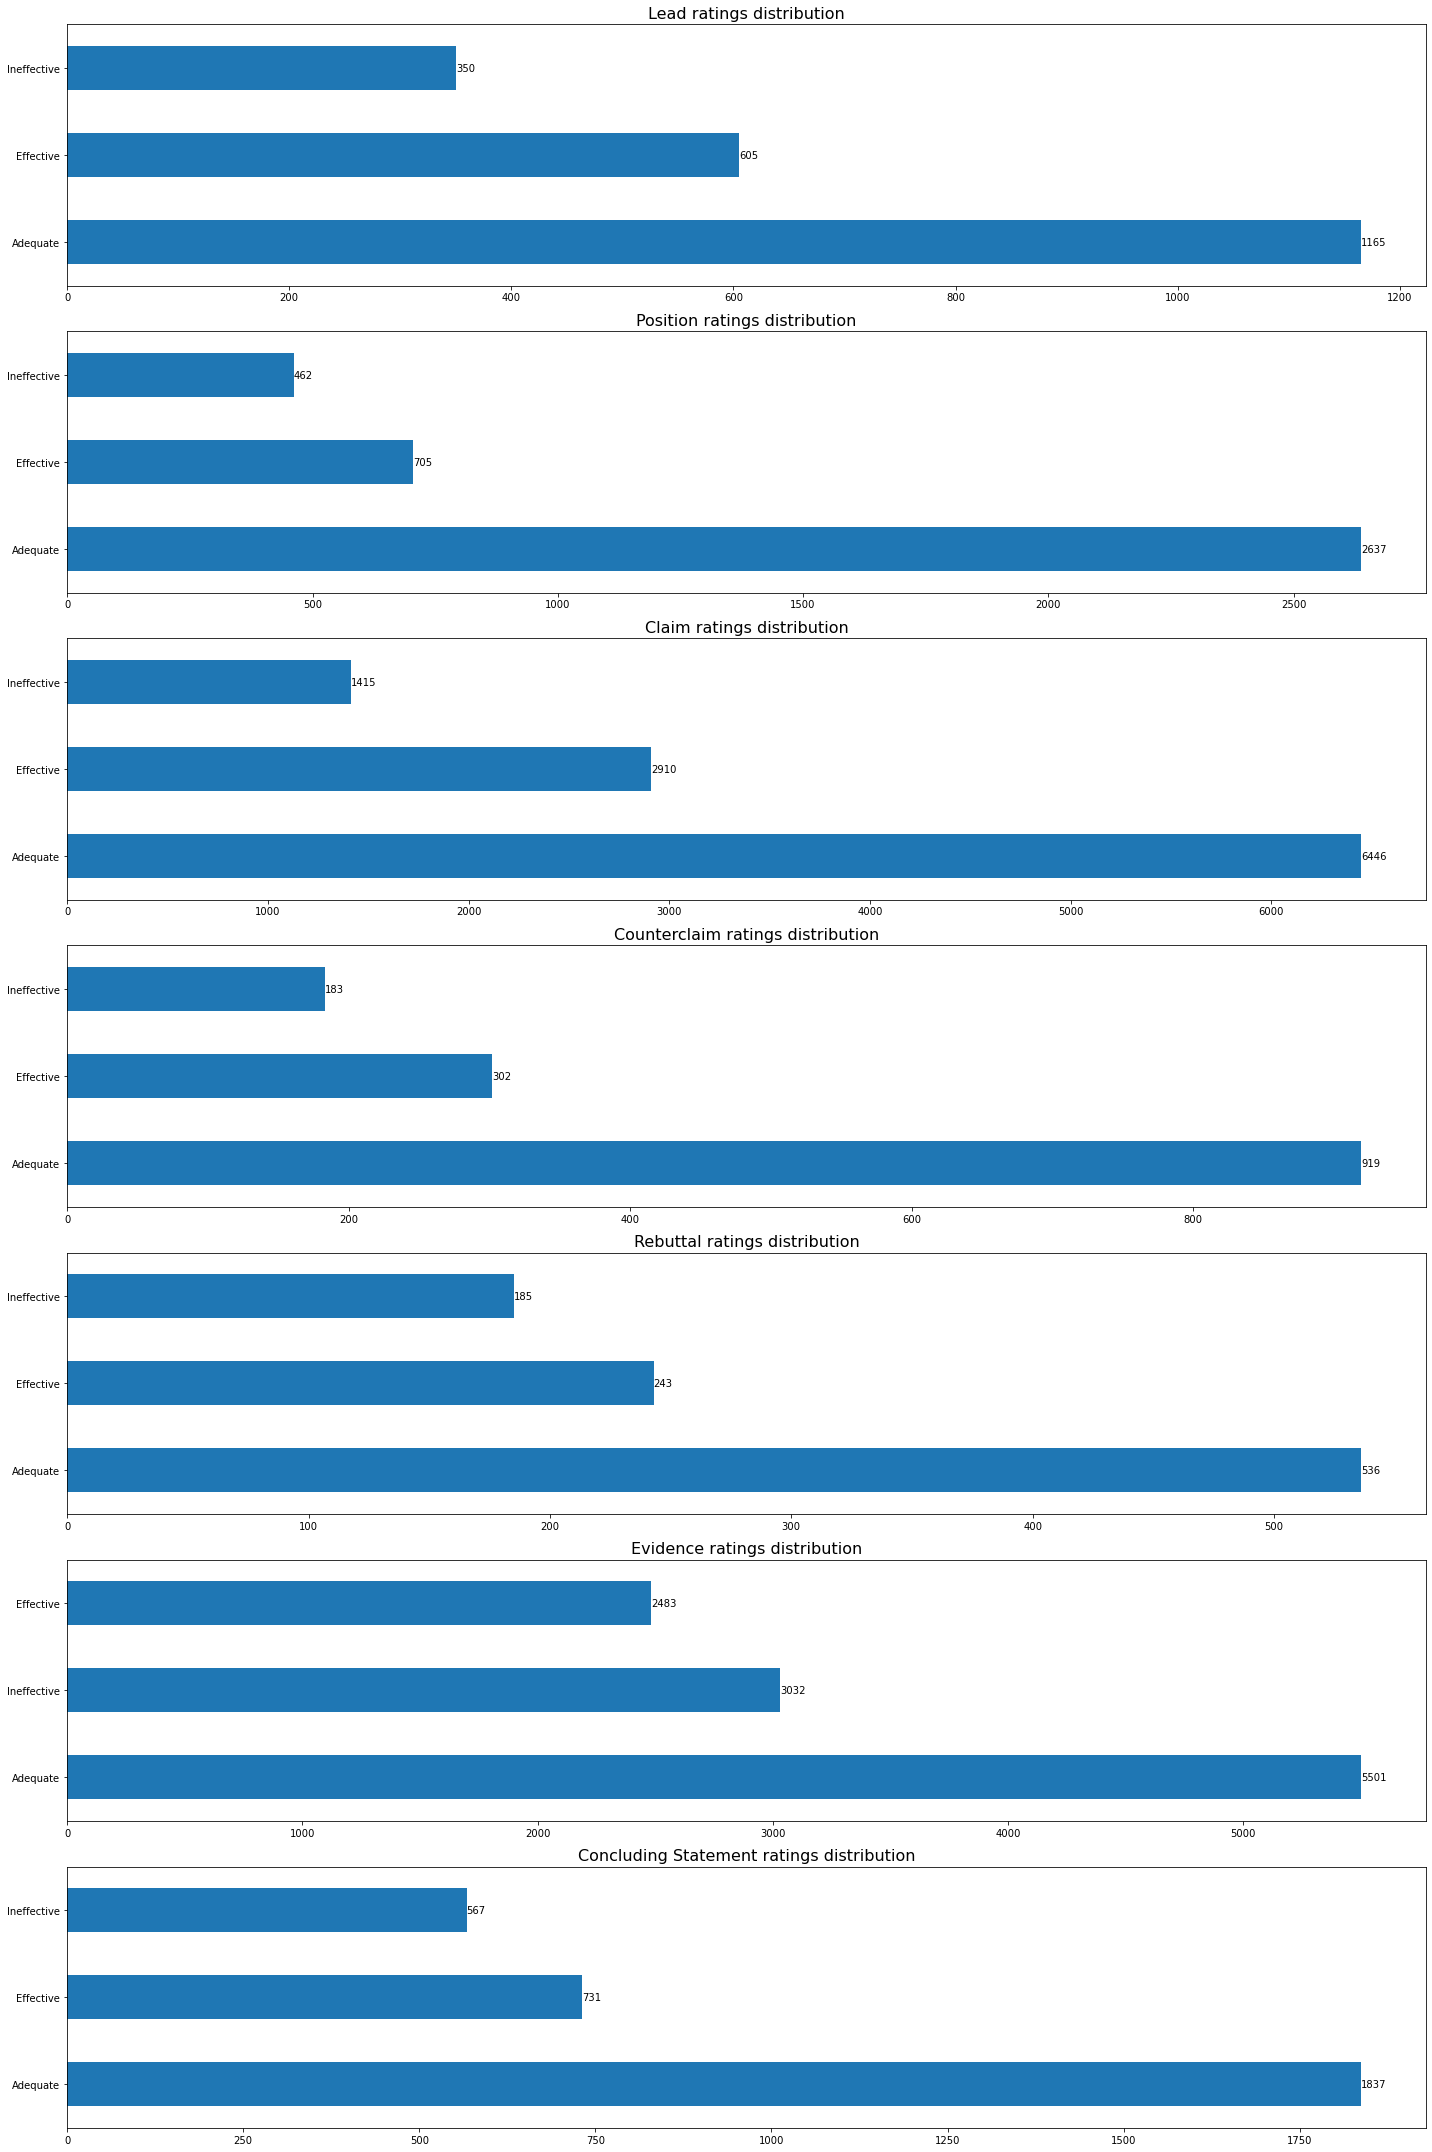

In [3]:
import matplotlib.pyplot as plt

discourse_types = ["Lead", "Position", "Claim", "Counterclaim", "Rebuttal", "Evidence", "Concluding Statement"]
fig, axs = plt.subplots(7, 1)

axs = axs.flatten()
for i, discourse_type in enumerate(discourse_types):
    axs[i] = (train_df.loc[train_df.discourse_type == discourse_type]
              .discourse_effectiveness.value_counts().plot(kind='barh', ax=axs[i], figsize=(20, 30)))
    axs[i].set_title(f"{discourse_type} ratings distribution", fontsize=16)
    axs[i].bar_label(axs[i].containers[0], label_type="edge")
    
plt.tight_layout()
plt.show()

In all discourse types the most frequent evaluation is "Adequate"!

## Text preprocessing

In [4]:
import string
import spacy
from spacy.lang.en import English

import nltk

nlp = spacy.load("en_core_web_trf", disable=['ner', 'parser', 'lemmatizer', 'textcat'])
parser = English()

def punctuation_removal(tokens):
    punctuations = string.punctuation
    tokens = [token for token in tokens if token not in punctuations]
    return tokens

def stopwords_removal(tokens):
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    tokens = [token for token in tokens if token not in stopwords]
    return tokens

def stemming(tokens):
    porter = nltk.PorterStemmer()
    stems = [porter.stem(token) for token in tokens]
    return stems
    
def lemmatization(tokens):
    wordnet_lemmatizer = nltk.WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    return lemmas
    
def spacy_tokenizer(phrase, steps=[punctuation_removal]):
    phrase = phrase.strip().lower()
    tokens = parser(phrase)
    tokens = [token.text for token in tokens]
    
    for step in steps:
        tokens = step(tokens)
    
    return tokens

In [5]:
train_df["discourse_tokens"] = train_df.discourse_text.map(lambda x: spacy_tokenizer(x))

### TF - IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = train_df.discourse_tokens
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
vectors = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.get_feature_names_out()

In [7]:
train_df = pd.concat([train_df, pd.DataFrame(vectors)[0]], axis=1)
train_df = train_df.rename(columns={0: 'tf_idf_vector'})

In [8]:
def get_tf_idf_dict(tf_idf_vector):
    tf_idf_vector = tf_idf_vector.toarray().squeeze()
    nonzero = tf_idf_vector.nonzero()
    return dict(zip(vocabulary[nonzero], tf_idf_vector[nonzero]))

train_df["tf_idf_dict"] = train_df.tf_idf_vector.map(get_tf_idf_dict)

### Embeddings

In [9]:
import gensim
import gensim.downloader

model_w2v = gensim.downloader.load("word2vec-google-news-300")

In [10]:
import numpy as np

train_df["embeddings"] = train_df.tf_idf_dict.map(
    lambda dict: [model_w2v[key] * value for (key, value) in dict.items() if key in model_w2v])

In [11]:
train_df["embeddings_number"] = train_df.embeddings.map(len)
train_df = train_df.loc[train_df.embeddings_number > 0]

In [12]:
train_df["doc_embedding"] = train_df.embeddings.map(lambda embeddings: np.array(embeddings).mean(axis=0))
train_df = train_df.drop(columns=['embeddings_number', 'embeddings', 'tf_idf_vector', 'tf_idf_dict', 'discourse_tokens'])

## Argumentation graph

In [13]:
clauses = []

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(row):
    return cosine_similarity([row.doc_embedding_x, row.doc_embedding_y])[0, 1]

### Analyze evidences
Assert supports from evidences to claims, counterclaims or rebuttals

In [15]:
def evidences_support_claims(essay):
    evidences = essay.loc[essay.discourse_type == "Evidence"]
    claims = essay.loc[
        (essay.discourse_type == 'Claim') |
        (essay.discourse_type == 'Counterclaim') |
        (essay.discourse_type == 'Rebuttal')]

    if not evidences.empty and not claims.empty:
        merge = evidences.merge(claims, on="essay_id")
        merge = pd.concat([merge, merge.apply(compute_similarity, axis=1)], axis=1)
        merge = merge.rename(columns={0: 'similarity'})
        merge = merge.reset_index(drop=True)

        for id, evidence in merge.groupby(merge.discourse_id_x):
            clauses.append(f"support('{id}', '{evidence.iloc[evidence.similarity.argmax(), :].discourse_id_y}').")
            clauses.append(f"rel_weight('{id}', '{evidence.iloc[evidence.similarity.argmax(), :].discourse_id_y}', {evidence.iloc[evidence.similarity.argmax(), :].similarity}).")

### Analyze claims and counterclaims
Assert supports from claims to position

In [16]:
def claims_support_position(essay):
    claims = essay.loc[essay.discourse_type == "Claim"]
    position = essay.loc[essay.discourse_type == "Position"]

    if not claims.empty and not position.empty:
        merge = claims.merge(position, on="essay_id")
        merge = pd.concat([merge, merge.apply(compute_similarity, axis=1)], axis=1)
        merge = merge.rename(columns={0: 'similarity'})
        merge = merge.reset_index(drop=True)

        for id, claim in merge.groupby(merge.discourse_id_x):
            for _, position in claim.iterrows():
                clauses.append(f"support('{id}', '{position.discourse_id_y}').")
                clauses.append(f"rel_weight('{id}', '{position.discourse_id_y}', {position.similarity}).")

Assert attacks from counterclaims to position

In [17]:
def counterclaims_attack_position(essay):
    counterclaims = essay.loc[essay.discourse_type == "Counterclaim"]
    position = essay.loc[essay.discourse_type == "Position"]

    if not counterclaims.empty and not position.empty:
        merge = counterclaims.merge(position, on="essay_id")
        merge = pd.concat([merge, merge.apply(compute_similarity, axis=1)], axis=1)
        merge = merge.rename(columns={0: 'similarity'})
        merge = merge.reset_index(drop=True)

        for id, counterclaim in merge.groupby(merge.discourse_id_x):
            for _, position in counterclaim.iterrows():
                clauses.append(f"attack('{id}', '{position.discourse_id_y}').")
                clauses.append(f"rel_weight('{id}', '{position.discourse_id_y}', {-position.similarity}).")

Assert attacks from counterclaims to claims and the other way round

In [18]:
def counterclaims_attack_claims(essay):
    counterclaims = essay.loc[essay.discourse_type == "Counterclaim"]
    claims = essay.loc[essay.discourse_type == "Claim"]

    if not counterclaims.empty and not claims.empty:
        merge = counterclaims.merge(claims, on="essay_id")
        merge = pd.concat([merge, merge.apply(compute_similarity, axis=1)], axis=1)
        merge = merge.rename(columns={0: 'similarity'})
        merge = merge.reset_index(drop=True)

        for id, counterclaim in merge.groupby(merge.discourse_id_x):
            for _, claim in counterclaim.iterrows():
                clauses.append(f"attack('{id}', '{claim.discourse_id_y}').")
                clauses.append(f"attack('{claim.discourse_id_y}', '{id}').")
                clauses.append(f"rel_weight('{id}', '{claim.discourse_id_y}', {-claim.similarity}).")
                clauses.append(f"rel_weight('{claim.discourse_id_y}', '{id}', {-claim.similarity}).")

### Analyze rebuttals
Assert attacks from rebuttals to counterclaims

In [19]:
def rebuttals_attack_counterclaims(essay):
    rebuttals = essay.loc[essay.discourse_type == "Rebuttal"]
    counterclaims = essay.loc[essay.discourse_type == "Counterclaim"]

    if not rebuttals.empty and not counterclaims.empty:
        merge = rebuttals.merge(counterclaims, on="essay_id")
        merge = pd.concat([merge, merge.apply(compute_similarity, axis=1)], axis=1)
        merge = merge.rename(columns={0: 'similarity'})
        merge = merge.reset_index(drop=True)

        for id, rebuttal in merge.groupby(merge.discourse_id_x):
            for _, counterclaim in rebuttal.iterrows():
                clauses.append(f"attack('{id}', '{counterclaim.discourse_id_y}').")
                clauses.append(f"rel_weight('{id}', '{counterclaim.discourse_id_y}', {-counterclaim.similarity}).")

### Analyze concluding statement

In [20]:
def conclusion_supports_claims(essay):
    conclusion = essay.loc[essay.discourse_type == "Concluding Statement"]
    claims = essay.loc[essay.discourse_type == "Claim"]

    if not conclusion.empty and not claims.empty:
        merge = conclusion.merge(claims, on="essay_id")
        merge = pd.concat([merge, merge.apply(compute_similarity, axis=1)], axis=1)
        merge = merge.rename(columns={0: 'similarity'})
        merge = merge.reset_index(drop=True)

        for id, conclusion in merge.groupby(merge.discourse_id_x):
            for index, claim in conclusion.iterrows():
                clauses.append(f"support('{id}', '{claim.discourse_id_y}').")
                clauses.append(f"rel_weight('{id}', '{claim.discourse_id_y}', {claim.similarity}).")

In [21]:
# essay = train_df.loc[train_df.essay_id == '00066EA9880D']

# essay = essay.loc[:, ['essay_id', 'discourse_id', 'discourse_type', 'doc_embedding']]

# arguments = essay.discourse_id.map(lambda id: f"argument('{id}').").values.tolist()
# clauses = []
# evidences_support_claims(essay)
# print(clauses)

In [22]:
from tqdm import tqdm

afs_dir = '../data/afs'

for essay_id, essay in tqdm(train_df.groupby(train_df.essay_id)):
    essay = essay.loc[:, ['essay_id', 'discourse_id', 'discourse_type', 'doc_embedding']]

    arguments = essay.discourse_id.map(lambda id: f"argument('{id}').").values.tolist()
    clauses = []
    evidences_support_claims(essay)
    claims_support_position(essay)
    counterclaims_attack_position(essay)
    counterclaims_attack_claims(essay)
    rebuttals_attack_counterclaims(essay)
    conclusion_supports_claims(essay)

    with open(f'{afs_dir}/{essay_id}.bwaf', 'w') as f:
        f.write('\n'.join(arguments))
        f.write('\n')
        f.write('\n'.join(clauses))

100%|██████████| 3972/3972 [01:12<00:00, 54.75it/s]


In [23]:
with open('../data/bwafs', 'w') as f:
    for essay_id, essay in tqdm(train_df.groupby(train_df.essay_id)):
        f.write(f"'../../data/afs/{essay_id}'.")
        f.write('\n')

100%|██████████| 3972/3972 [00:00<00:00, 76689.75it/s]
